In [1]:
#Task:
#Create code using python `xarray` to organize and reduce climate data.
#The goal of this analysis will be to detect global atmospheric circulation patterns (or teleconnections) associated with extreme daily precipitation in a certain part of the globe.

In [2]:
#(1) Use the precipitation output of ERA-5 to compute a time series of daily precipitation at a given point closest to a city of your choosing. 
# Choose a box of 5 x 5 deg lat-lon values over the grid box closest to the city you are examining.  
# Save this data.  
# Use a period of at least 10 years.

In [3]:
# City of choice: NYC
# Lat: 38 to 42 degrees N
# Lon: -71 to -76 W
# Lon converted to 360 coordinates: (360-76=284) (360-71=289)

In [1]:
#Import necessary packages
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

In [3]:
# Import dask into my python session
from dask.distributed import Client, progress
import dask

In [4]:
# Create a dask local client object
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39257,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37339,Total threads: 1
Dashboard: http://127.0.0.1:35181/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:44907,


In [5]:
#Import google cloud storage file system
import gcsfs
fs = gcsfs.GCSFileSystem(token='anon')
print(fs.ls('gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3')[:10])

['gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_wind_gust_since_previous_post_processing']


In [6]:
# Open zarr using ARCO (analysis-ready and cloud optimized) ERA5 dataset via google research GitHub link https://github.com/google-research/arco-era5


ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
ar_full_37_1h = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))

ar_full_37_1h


<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 3TB ...
Attributes:
    last_updated:           2025-09-24 01:56:16.783170+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-18

In [7]:
#Start to subset the data we want for NYC from 2000-2015

#sel allows us to use dimensions and values
#isel uses integer indices to select

#Define the variable we are interested in: total_precipitation

var = 'total_precipitation'


dss = ar_full_37_1h[var].sel(time=slice('2000-01-01 00:00','2015-12-31 23:59'))

dss

<xarray.DataArray 'total_precipitation' (time: 140256, latitude: 721,
                                         longitude: 1440)> Size: 582GB
[145619389440 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1MB 2000-01-01 ... 2015-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [8]:
#Create another data array subsetting for our variable of interest and latitude/longitude range
#Reverse latitude to go from higher lat to lower lat

NYCprecip = dss.sel(latitude=slice(42, 38), longitude=slice(284, 289))

NYCprecip

<xarray.DataArray 'total_precipitation' (time: 140256, latitude: 17,
                                         longitude: 21)> Size: 200MB
[50071392 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 68B 42.0 41.75 41.5 41.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float32 84B 284.0 284.2 284.5 ... 288.5 288.8 289.0
  * time       (time) datetime64[ns] 1MB 2000-01-01 ... 2015-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

Text(0.5, 1.0, 'Precipitation Time Series over NYC')

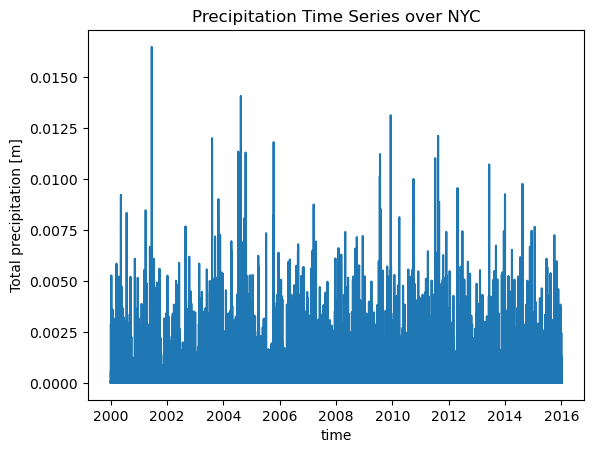

In [12]:
#Plot a time series for a given point. Using lat=41.0, lon=287 as the specific point. 

#Generate a plot for this data point
NYCprecip.sel(latitude=41, longitude=287).plot()
#Add a title to the plot
plt.title('Precipitation Time Series over NYC')

In [13]:
# (2) Determine the 95% values of daily precipitation for the data created in (1)
# Plot a cumulative distribution function of all daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

In [9]:
# Determine the 95% values of daily precipitation for the data created in (1)

# Calculate the 95th percentile of the 5x5 grid NYC precip data
percentile95 = NYCprecip.quantile(.95)

# Filter the array to only include values in the 95th percentile
filtered_values = NYCprecip.where(NYCprecip>=percentile95, drop=True)

# Create a new data array with only the filtered values

NYCprecip95 = filtered_values

print(percentile95)

print(NYCprecip95)

<xarray.DataArray 'total_precipitation' ()> Size: 8B
array(0.00083644)
Coordinates:
    quantile  float64 8B 0.95
<xarray.DataArray 'total_precipitation' (time: 46319, latitude: 17,
                                         longitude: 21)> Size: 66MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
 

In [15]:
# Need to convert all daily precip values and 95% quantile values from meters to millimeters (x1000)

In [10]:
# Convert 95% quantile values to mm
multiplier = 1000
NYCprecip95mm = NYCprecip95 * multiplier

NYCprecip95mm

<xarray.DataArray 'total_precipitation' (time: 46319, latitude: 17,
                                         longitude: 21)> Size: 66MB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [1.183845 , 0.9962097,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [1.001047 , 0.8956231,       nan, ...,       nan,       nan,
               nan]]], shape=(46319, 17, 21), dtype=float32)
Coordinates:
  * latitude   (latitude) float32 68B 42.0 41.75 41.5 41.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float32 84B 284.0 284.2 284.5 ... 288.5 288.8 289.0
  * time       (time) datetime64[ns] 371kB 2000-01-02T15:00:00 ... 2015-12-31...
    quantile   float64 8B 0.95

In [11]:
# Convert all precip values to mm
multiplier = 1000
NYCprecipmm = NYCprecip * multiplier

NYCprecipmm

<xarray.DataArray 'total_precipitation' (time: 140256, latitude: 17,
                                         longitude: 21)> Size: 200MB
array([[[-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
         -9.3132257e-07, -9.3132257e-07, -9.3132257e-07],
        [-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
         -9.3132257e-07, -9.3132257e-07, -9.3132257e-07],
        [-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
         -9.3132257e-07, -9.3132257e-07, -9.3132257e-07],
        ...,
        [-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
          1.7313287e-03,  1.5159138e-02,  2.9885210e-02],
        [-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
          6.4959750e-03,  1.9056723e-02,  3.8114376e-02],
        [-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
          1.4725141e-02,  2.6419759e-02,  4.6343543e-02]],

       [[-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
         -9.3132257e-07, -9.3132257e-07, -9.3132257e-07],
        [-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
         -9.3132257e-07, -9.3132257e-07, -9.3132257e-07],
        [-9.3132257e-07, -9.3132257e-07, -9.3132257e-07, ...,
         -9.3132257e-07, -9.3132257e-07, -9.3132257e-07],
...
          8.7048858e-02,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          4.5459718e-02,  2.9020011e-03,  9.6857548e-04],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          5.9965998e-02,  1.6443431e-02,  1.3541430e-02]],

       [[ 9.6857548e-04,  9.6857548e-04,  9.6857548e-04, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          2.9984862e-02,  4.8354268e-03,  1.9371510e-03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          6.5770000e-02,  7.6409429e-02,  8.7060034e-03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.3830885e-01,  1.1412799e-01,  5.1263720e-02]]],
      shape=(140256, 17, 21), dtype=float32)
Coordinates:
  * latitude   (latitude) float32 68B 42.0 41.75 41.5 41.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float32 84B 284.0 284.2 284.5 ... 288.5 288.8 289.0
  * time       (time) datetime64[ns] 1MB 2000-01-01 ... 2015-12-31T23:00:00

/home/hildebr1/envs/xarray-climate/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


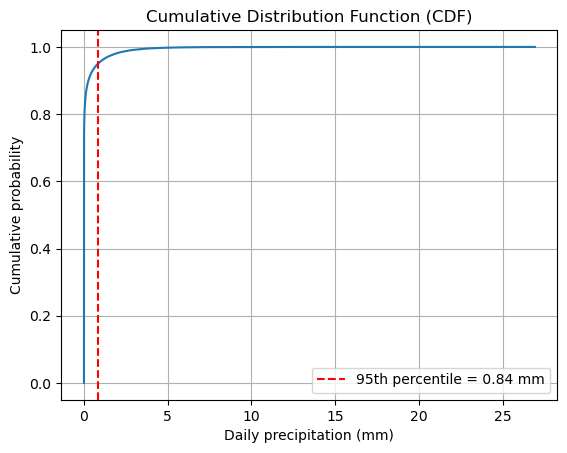

In [18]:
# Plot a cumulative distribution function of all daily precip values and illustrate the 95% value of daily precip. 

# Flatten all daily precip values to 1 dimension (removing lat and lon)
allprecip_1d = NYCprecipmm.values.flatten()

# Remove NaNs
allprecip_1d = allprecip_1d[~np.isnan(allprecip_1d)]

# Sort the precip data
sorted_data = np.sort(allprecip_1d)

# Determine the cumulative probabilities (y-axis values for the CDF) - divide the rank of each sorted data point by the total number of data points.
n = len(sorted_data)
cumulative_probabilities = np.arange(1, n+1)/n

#The 95th percentile was 0.00083644 meters, which converts to 0.83644 mm. 

# Plot the CDF using matplotlib
plt.plot(sorted_data, cumulative_probabilities)
plt.axvline(0.83644, color="red", linestyle="--", label=f"95th percentile = 0.84 mm")
plt.xlabel("Daily precipitation (mm)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF)")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# (3) Create a map of the composite mean precipitation on the 95% days identified in (2) over the continental USA,
# and a map of the anomaly of precipitation from the 1981-2010 mean.
# This field should be plotted on a Cartopy map centered at your city with a 40 x 40 degree lat-lon range. 

In [12]:
# Get list of the 95% days from (2) - unique days where at least one grid cell exceeds the threshold

mask=NYCprecip95mm

days_95 = NYCprecip95mm['time'].where(mask.any(dim=("latitude", "longitude")), drop=True)

days_95

<xarray.DataArray 'time' (time: 46319)> Size: 371kB
array(['2000-01-02T15:00:00.000000000', '2000-01-02T16:00:00.000000000',
       '2000-01-02T17:00:00.000000000', ...,
       '2015-12-31T15:00:00.000000000', '2015-12-31T17:00:00.000000000',
       '2015-12-31T18:00:00.000000000'],
      shape=(46319,), dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 371kB 2000-01-02T15:00:00 ... 2015-12-31T...
    quantile  float64 8B 0.95

In [21]:
# The time stamps seems to be hourly? 
# 46,319 date fields
# 46,319 / 24 = 1,930 days
# 1,930 / 15 years = 128.6 days/year


In [13]:
# Create a new dataarray using the list of unique datetimes from days_95 and pull lat/lon/precip data from the original dataarray, dss, for the 40 x 40 degree lat-lon range:
# lat = 20-60
# lon = 265-305

# Subset the dss to match the spatial domain needed
dss_subset = dss.sel(latitude=slice(60, 20), longitude=slice(265, 305))

# Select only the datetimes that match those in the 'days_95' array
precip_95days = dss_subset.sel(time=days_95.time)

# Print precip_95days to make sure lat, lon, precip are there
precip_95days

<xarray.DataArray 'total_precipitation' (time: 46319, latitude: 161,
                                         longitude: 161)> Size: 5GB
[1200634799 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 644B 60.0 59.75 59.5 59.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float32 644B 265.0 265.2 265.5 ... 304.5 304.8 305.0
  * time       (time) datetime64[ns] 371kB 2000-01-02T15:00:00 ... 2015-12-31...
    quantile   float64 8B 0.95
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [ ]:
# Plot the composite mean of precip_95days (mm)

multiplier = 1000
precip_95days_mm = precip_95days * multiplier

precip_95days_mean = precip_95days_mm.mean(dim="time")

fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

precip_95days_mean.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    cbar_kwargs={"label": "Mean Precipitation (mm)"}
)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_extent([265, 305, 20, 60], crs=ccrs.PlateCarree())
ax.set_title("Composite Mean Precipitation on 95th Percentile Days")

plt.show()